# Convolutional Autoencoder plus Perceptron

## Imports and definitions

### Model Class and Loss Function Definitions

In [1]:
# %load ml/models/convolutional_autoencoder_plus_perceptron.py
from torch import nn
from torch.nn import functional as F


class ConvolutionalLayer(nn.Module):
    def __init__(self, *, in_channels, out_channels,
            stride=2, kernel_size=3, padding=1, bias=False):
        super().__init__()
        self.bn = nn.BatchNorm2d(num_features=in_channels)
        self.conv = nn.Conv2d(in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                kernel_size=kernel_size,
                padding=padding,
                bias=bias)
        self.relu = nn.ReLU()

    def forward(self, x_in):
        x = self.bn(x_in)
        x = self.conv(x)
        x = self.relu(x)
        return x


class DeconvolutionalLayer(nn.Module):
    def __init__(self, *, in_channels, out_channels,
            stride=2, kernel_size=3, padding=1,
            output_padding=1, bias=False, activation=nn.ReLU()):
        super().__init__()
        self.bn = nn.BatchNorm2d(num_features=in_channels)
        self.deconv = nn.ConvTranspose2d(in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                kernel_size=kernel_size,
                padding=padding,
                output_padding=output_padding,
                bias=bias)
        self.activation = activation

    def forward(self, x_in):
        x = self.bn(x_in)
        x = self.deconv(x)
        x = self.activation(x)
        return x


class Perceptron(nn.Module):
    def __init__(self, *, in_features, hidden_features, output_features):
        super().__init__()

        self.bn1 = nn.BatchNorm1d(num_features=in_features)
        self.linear1 = nn.Linear(in_features=in_features,
                out_features=hidden_features)

        self.bn2 = nn.BatchNorm1d(num_features=hidden_features)
        self.linear2 = nn.Linear(in_features=hidden_features,
                out_features=hidden_features)

        self.bn3 = nn.BatchNorm1d(num_features=hidden_features)
        self.linear3 = nn.Linear(in_features=hidden_features,
                out_features=output_features)

        self.relu = nn.ReLU()

    def forward(self, x_in):
        x = self.bn1(x_in)
        x = self.linear1(x)
        x = self.relu(x)

        x = self.bn2(x)
        x = self.linear2(x)
        x = self.relu(x)

        x = self.bn3(x)
        x = self.linear3(x)
        return x


class ConvolutionalAutoencoderPlusPerceptron(nn.Module):
    def __init__(self, image_channels, conv_channels, hidden_features,
            perceptron_features, conv_bias=False):
        super().__init__()

        self.conv0 = ConvolutionalLayer(
                in_channels=image_channels,
                out_channels=conv_channels[0],
                kernel_size=7,
                stride=1,
                padding=3,
                bias=conv_bias)

        self.conv1 = ConvolutionalLayer(
                in_channels=conv_channels[0],
                out_channels=conv_channels[1],
                bias=conv_bias)

        self.conv2 = ConvolutionalLayer(
                in_channels=conv_channels[1],
                out_channels=conv_channels[2],
                bias=conv_bias)

        self.conv3 = ConvolutionalLayer(
                in_channels=conv_channels[2],
                out_channels=conv_channels[3],
                padding=2,
                bias=conv_bias)

        self.deconv3 = DeconvolutionalLayer(
                in_channels=conv_channels[3],
                out_channels=conv_channels[2],
                padding=2,
                output_padding=0,
                bias=conv_bias)

        self.deconv2 = DeconvolutionalLayer(
                in_channels=conv_channels[2],
                out_channels=conv_channels[1],
                bias=conv_bias)

        self.deconv1 = DeconvolutionalLayer(
                in_channels=conv_channels[1],
                out_channels=conv_channels[0],
                bias=conv_bias)

        self.deconv0 = DeconvolutionalLayer(
                activation=nn.Sigmoid(),
                in_channels=conv_channels[0],
                out_channels=image_channels,
                stride=1,
                kernel_size=7,
                padding=3,
                output_padding=0,
                bias=conv_bias)

        self.perceptron_input_size = 5*5*conv_channels[-1]
        self.perceptron = Perceptron(
                in_features=self.perceptron_input_size,
                hidden_features=hidden_features,
                output_features=perceptron_features)

        self.autoencoder_ratio = 0.95

    def encode(self, x_in, **kwargs):
        x = self.conv0(x_in)
        x = self.conv1(x)
        x = self.conv2(x)
        x_latent = self.conv3(x)
        return x_latent

    def decode(self, x_latent):
        x = self.deconv3(x_latent)
        x = self.deconv2(x)
        x = self.deconv1(x)
        x_out = self.deconv0(x)
        return x_out

    def forward(self, x_in, **kwargs):
        x_latent = self.encode(x_in)
        y_out = self.perceptron(x_latent.view(-1, self.perceptron_input_size))
        x_out = self.decode(x_latent)
        return {'x_out': x_out, 'y_out': y_out}

    def calculate_losses(self, x_out, x_in, y_in, y_out, **kwargs):
        reconstruction_loss = F.binary_cross_entropy(x_out, x_in.view_as(x_out),
                size_average=False) / (x_in.shape[-1] * x_in.shape[-2])
        perceptron_loss = nn.CrossEntropyLoss()(input=y_out,
                target=y_in)
        total_loss = ((self.autoencoder_ratio * reconstruction_loss) +
               (1 - self.autoencoder_ratio) * perceptron_loss)

        return {'reconstruction_loss': reconstruction_loss,
                'perceptron_loss': perceptron_loss,
                'total_loss': total_loss}


### Trainer Class Definition

## Datasets and Loaders

In [2]:
import torch

RANDOM_SEED = 1

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

kwargs = {
    'batch_size': 500,
    'num_workers': 1,
    'pin_memory': True,
    'shuffle': True
}

mnist_dataset = datasets.FashionMNIST('data/fashion-mnist',
    train=True, download=True, transform=transforms.ToTensor())
training_loader = DataLoader(mnist_dataset, **kwargs)
    
mnist_test_dataset = datasets.FashionMNIST('data/fashion-mnist',
    train=False, transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test_dataset, **kwargs)

In [4]:
from torch import optim
from ml.trainer import Trainer

def get_trainer(conv_channels=2, hidden_features=128,
                momentum=0.9, weight_decay=0.0):
    model = ConvolutionalAutoencoderPlusPerceptron(
        image_channels=1,
        hidden_features=hidden_features,
        perceptron_features=10,
        conv_channels=conv_channels)
    model.cuda()
    optimizer = optim.SGD(model.parameters(), lr=1e-4,
                          momentum=momentum,
                          weight_decay=weight_decay)

    trainer = Trainer(model=model, optimizer=optimizer,
        # this is a closure over the rest of these
        training_data_loader=training_loader,
        test_data_loader=test_loader)
    return trainer

## Results

In [5]:
def train_convolutional_ae(trainer, learning_rate, cycles):
    trainer.multi_train(learning_rate=learning_rate, cycles=cycles)
    print(f'Final Test Loss: {trainer.test(): 0.3f}')
    print(f'Number of trainable parameters: {trainer.num_trainable_parameters}')
    print(f'Classification Accuracy: {trainer.get_classification_accuracy()}')
    trainer.plot_history()
    trainer.plot_input_output_pairs()

600/600 [==============================] - 45s 76ms/step - loss: 125.2350 - val_loss: 127.0339
Final Test Loss:  0.251
Number of trainable parameters: 253196
Classification Accuracy: 0.665


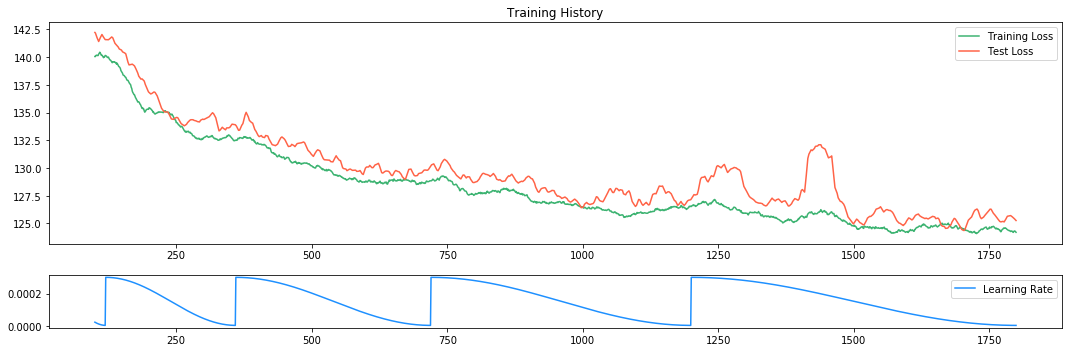

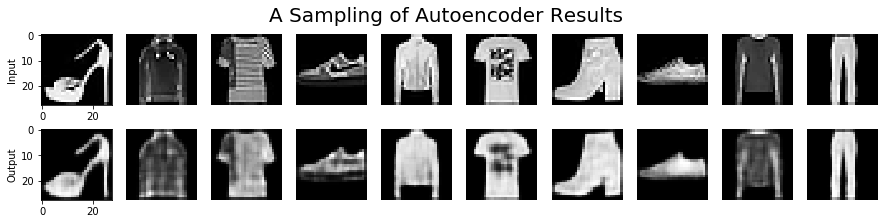

In [6]:
trainer = get_trainer(conv_channels=[40, 4, 4*4, 4*4*4])
train_convolutional_ae(trainer, learning_rate=3e-4, cycles=5)

360/360 [==============================] - 27s 76ms/step - loss: 117.6170 - val_loss: 120.5401
Final Test Loss:  0.235
Number of trainable parameters: 253196
Classification Accuracy: 0.7231


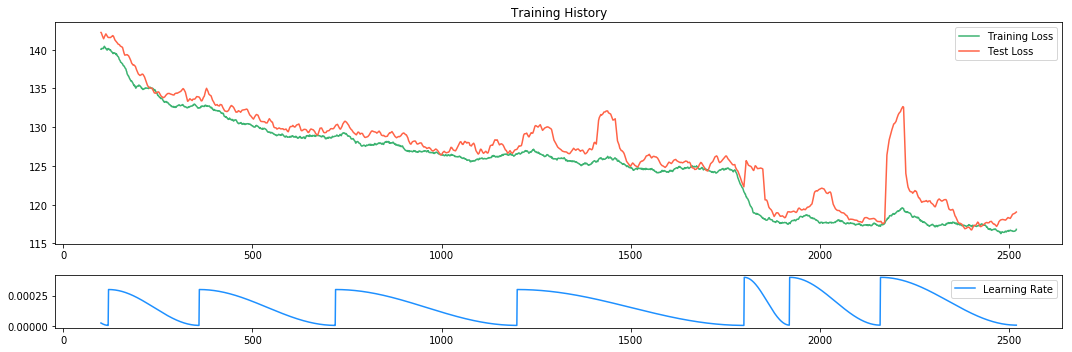

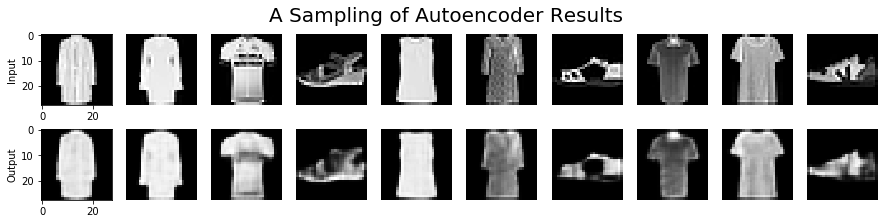

In [7]:
trainer.model.autoencoder_ratio = 0.90
train_convolutional_ae(trainer, learning_rate=4e-4, cycles=3)